### Import modules

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# General
import os
import random

# Data processing, storage
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Image processing
import cv2 # opencv-python
from PIL import Image

# Data plotting
import matplotlib.pyplot as plt

# Machine learning
import tensorflow as tf
from sklearn import metrics

In [2]:
tf.__version__

'2.4.1'

In [3]:
# Check if tensorflow can find GPU
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)
print(gpus)

Name: /physical_device:GPU:0   Type: GPU
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13245831790989490320,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15685569792
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11240840967956140955
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [6]:
tf.test.is_gpu_available()

True

In [7]:
!nvidia-smi

Wed Feb 24 07:57:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    34W / 250W |    367MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Check input data availability

In [8]:

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname, "contains", len(filenames), "files.")
    #for filename in filenames:
    #    print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input contains 0 files.
/kaggle/input/p7eglmltilesshiftrotate contains 0 files.
/kaggle/input/p7eglmltilesshiftrotate/P7-EGL-ML-tiles-shift-rotate contains 1 files.
/kaggle/input/p7eglmltilesshiftrotate/P7-EGL-ML-tiles-shift-rotate/test contains 0 files.
/kaggle/input/p7eglmltilesshiftrotate/P7-EGL-ML-tiles-shift-rotate/test/EGL contains 270 files.
/kaggle/input/p7eglmltilesshiftrotate/P7-EGL-ML-tiles-shift-rotate/test/ML contains 270 files.
/kaggle/input/p7eglmltilesshiftrotate/P7-EGL-ML-tiles-shift-rotate/train contains 0 files.
/kaggle/input/p7eglmltilesshiftrotate/P7-EGL-ML-tiles-shift-rotate/train/EGL contains 1080 files.
/kaggle/input/p7eglmltilesshiftrotate/P7-EGL-ML-tiles-shift-rotate/train/ML contains 1080 files.


### Set parameters

In [9]:
basedatadir = '/kaggle/input/p7eglmltilesshiftrotate/P7-EGL-ML-tiles-shift-rotate'

train_data_dir = basedatadir + '/train'
test_data_dir = basedatadir + '/test'

# Calculation of max batch size-
# Max batch size= available GPU memory bytes / 4 / (size of tensors + trainable parameters)
# size of tensors = batch_size*100*100 *4 if using 64 bit integers

batch_size = 256
test_batch_size = 256
img_height = 300
img_width = 300
mean = 157.1
std = 64.6
AUTOTUNE = tf.data.experimental.AUTOTUNE

### Create FileList datasets
tf.data.Dataset.list_files() creates a dataset from a directory list of files using a matching pattern.

In [10]:
train_list_ds = tf.data.Dataset.list_files(str(train_data_dir + '/*/*'), shuffle=False)
# get the count of image files in the train directory
train_image_count=0
for dir1 in os.listdir(train_data_dir):
    for files in os.listdir(os.path.join(train_data_dir, dir1)):
        train_image_count+=1
train_list_ds = train_list_ds.shuffle(train_image_count, reshuffle_each_iteration=False)
print(train_image_count)

2160


In [11]:
# Print some filenames
for x in train_list_ds.take(5):
    print(x.numpy().decode('utf-8'))

/kaggle/input/p7eglmltilesshiftrotate/P7-EGL-ML-tiles-shift-rotate/train/EGL/R53_(21440,15372,1547).png
/kaggle/input/p7eglmltilesshiftrotate/P7-EGL-ML-tiles-shift-rotate/train/ML/R85_(32016,19516,2510)_rot90.png
/kaggle/input/p7eglmltilesshiftrotate/P7-EGL-ML-tiles-shift-rotate/train/EGL/R26_(23536,16628,689).png
/kaggle/input/p7eglmltilesshiftrotate/P7-EGL-ML-tiles-shift-rotate/train/EGL/R22_(22948,11776,525).png
/kaggle/input/p7eglmltilesshiftrotate/P7-EGL-ML-tiles-shift-rotate/train/EGL/R83_(23104,12476,2502)_rot45.png


In [12]:
test_list_ds = tf.data.Dataset.list_files(str(test_data_dir + '/*/*'), shuffle=False)
# get the count of image files in the train directory
test_image_count=0
for dir1 in os.listdir(test_data_dir):
    for files in os.listdir(os.path.join(test_data_dir, dir1)):
        test_image_count+=1
test_list_ds = test_list_ds.shuffle(test_image_count, reshuffle_each_iteration=False)
print(test_image_count)

540


In [13]:
# Print some filenames
for x in test_list_ds.take(5):
    print(x.numpy().decode('utf-8'))

/kaggle/input/p7eglmltilesshiftrotate/P7-EGL-ML-tiles-shift-rotate/test/EGL/R21_(11728,14560,525)_rot45.png
/kaggle/input/p7eglmltilesshiftrotate/P7-EGL-ML-tiles-shift-rotate/test/ML/R13_(30520,23540,209).png
/kaggle/input/p7eglmltilesshiftrotate/P7-EGL-ML-tiles-shift-rotate/test/ML/R60_(23384,21904,2144)_rot45.png
/kaggle/input/p7eglmltilesshiftrotate/P7-EGL-ML-tiles-shift-rotate/test/EGL/R12_(27664,12940,181).png
/kaggle/input/p7eglmltilesshiftrotate/P7-EGL-ML-tiles-shift-rotate/test/ML/R13_(30820,23240,209)_rot45.png


### Function to create list of files from tensorflow dataset

In [14]:
# Use this function to list files from a filelist dataset, such as test_list_ds.
# This may be useful later
list_files_from_tfdataset = lambda tfd: [f.numpy().decode('utf-8') for f in tfd]

In [15]:
#l = list_files_from_tfdataset(test_list_ds)
#print(len(l))
#del(l)
#test_ds_filepaths = test_list_ds.take(test_image_count)

### Create class labels from the directory name

In [16]:
class_names = np.array(sorted([dir1 for dir1 in os.listdir(train_data_dir)]))
class_names

array(['EGL', 'ML'], dtype='<U3')

### Split the dataset into train and val (Note that test dataset is already kept separate)
The validation dataset is 30% of the total dataset, and train dataset is 70% of the entire dataset.

In [17]:
# Create training and validation datasets
val_size = int(train_image_count * 0.3)
train_ds = train_list_ds.skip(val_size)
val_ds = train_list_ds.take(val_size)
print("Training images:", train_image_count-val_size, "\nValidation images:", val_size)

Training images: 1512 
Validation images: 648


In [18]:
# Different way of creatint training and validation datasets
# This is useful to select only small subset of the full data
#val_size = int(train_image_count * 0.01)
#train_size = int(train_image_count * 0.03)
#train_ds = train_list_ds.take(train_size)
#remaining_list_ds = train_list_ds.skip(train_size)
#val_ds = remaining_list_ds.take(val_size)
#print("Training images:", train_size, "\nValidation images:", val_size)

In [19]:
# Create test dataset
test_ds = test_list_ds.take(test_image_count)

In [20]:
# Print some filenames
print("Files from train_ds")
for x in train_ds.take(3):
    print(x.numpy().decode('utf-8'))
print("Files from val_ds")
for x in val_ds.take(3):
    print(x.numpy().decode('utf-8'))
print("Files from test_ds")
for x in test_ds.take(3):
    print(x.numpy().decode('utf-8'))

Files from train_ds
/kaggle/input/p7eglmltilesshiftrotate/P7-EGL-ML-tiles-shift-rotate/train/EGL/R78_(32852,11648,2334).png
/kaggle/input/p7eglmltilesshiftrotate/P7-EGL-ML-tiles-shift-rotate/train/EGL/R53_(21440,15372,1547)_rot90.png
/kaggle/input/p7eglmltilesshiftrotate/P7-EGL-ML-tiles-shift-rotate/train/ML/R78_(33616,22080,2464).png
Files from val_ds
/kaggle/input/p7eglmltilesshiftrotate/P7-EGL-ML-tiles-shift-rotate/train/EGL/R53_(21440,15372,1547).png
/kaggle/input/p7eglmltilesshiftrotate/P7-EGL-ML-tiles-shift-rotate/train/ML/R85_(32016,19516,2510)_rot90.png
/kaggle/input/p7eglmltilesshiftrotate/P7-EGL-ML-tiles-shift-rotate/train/EGL/R26_(23536,16628,689).png
Files from test_ds
/kaggle/input/p7eglmltilesshiftrotate/P7-EGL-ML-tiles-shift-rotate/test/EGL/R21_(11728,14560,525)_rot45.png
/kaggle/input/p7eglmltilesshiftrotate/P7-EGL-ML-tiles-shift-rotate/test/ML/R13_(30520,23540,209).png
/kaggle/input/p7eglmltilesshiftrotate/P7-EGL-ML-tiles-shift-rotate/test/ML/R60_(23384,21904,2144)_rot

### Create input pipeline components for a single training/validation example,<br>where a pair of tensors represents the image and its corresponding label.

In [21]:
#To process the label
def get_label(filepath):
    # convert the path to a list of path components separated by sep
    parts = tf.strings.split(filepath, os.path.sep)
    # The second to last is the class-directory
    one_hot = parts[-2] == class_names
    # Integer encode the label
    return tf.argmax(tf.cast(one_hot, tf.int32))
    
    #label = tf.strings.split(filepath, sep='/')
    #label = tf.strings.split(label[-1], sep='.')

# To process the image
def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    #img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.decode_png(img, channels=1)
    # resize the image to the desired size
    return tf.image.resize(img, [img_height, img_width])

# To create the single training of validation example with image and its corresponding label
def process_path(filepath):
    label = get_label(filepath)
    # load the raw data from the file as a string
    img = tf.io.read_file(filepath)
    img = decode_img(img)
    return img, label

### Create tf dataset of tensor by mapping the above functions to the filelist datasets<br>
Set the AUTOTUNE. This will help to delegate the decision on the level of parallelism<br>to use to the tf.data at runtime to optimize the CPU/GPU utilization.

In [22]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [23]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [24]:
# Test if the datasets are prepared correctly
for images, labels in train_ds.take(1):
    print(images.shape, labels.shape)
    img = images[0].numpy()
    print(img.min(), img.max(), img.dtype, labels.numpy())
    img = (img-5)/2 # Testing mathematical operations on tensor
    print(img.min(), img.max(), img.dtype, labels.numpy())

(300, 300, 1) ()
92.0 233.0 float32 0
43.5 114.0 float32 0


### Set augmentation and normalization functions

In [25]:
def augment(image, label):
    img = tf.image.rot90(image)
    img = tf.image.flip_left_right(img)
    #img = tf.clip_by_value(img, 0.0, 1.0)
    return img, label

def standardize_per_image(image, label):
    img = tf.image.per_image_standardization(image)
    return img, label

def standardize_dataset(image, label):
    # NOTE: mean and std have to be defined globally
    # Not checking that mean and std are > 0 to avoid time lag. So be careful with the values of mean and std.
    img = (image - mean)/std
    return img, label

### Configure data source for Performance
To configure the data source for performance, use prefetching. Prefetching in tf.data allows the preprocessing of the data and model execution of a training step to overlap. While the model is executing a training step 100, the input pipeline is reading the data for step 101.

In [26]:
def configure_for_performance(ds, cache_filename=''):
    if cache_filename == '':
        ds = ds.cache()
    else:
        ds = ds.cache(cache_filename)
    ds = ds.shuffle(buffer_size=1000)
    #ds = ds.map(augment, num_parallel_calls=AUTOTUNE) # No need if pre-augmented images.
    #ds = ds.map(standardize_per_image, num_parallel_calls=AUTOTUNE) # Use either of the two standardizations.
    ds = ds.map(standardize_dataset, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds, cache_filename='')#, '/home/harsh/tensorflow_cache/train_v5.train_ds')
val_ds = configure_for_performance(val_ds, cache_filename='')#, '/home/harsh/tensorflow_cache/train_v5.val_ds')

In [27]:
def configure_for_performance_forTestDataset(ds, cache_filename=''):
    if cache_filename == '':
        ds = ds.cache()
    else:
        ds = ds.cache(cache_filename)
    #ds = ds.shuffle(buffer_size=1000)
    #ds = ds.map(standardize_per_image, num_parallel_calls=AUTOTUNE) # Use either of the two standardizations.
    ds = ds.map(standardize_dataset, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(test_batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

test_ds = configure_for_performance_forTestDataset(test_ds, cache_filename='')#, '/home/harsh/tensorflow_cache/train_v5.test_ds')

(256, 300, 300, 1) (256,)
-2.4164088 1.3297213 float32 1


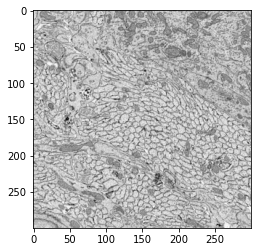

In [28]:
# Test that the pixels values are actually standardized and the images are properly stored.
for images, labels in train_ds.take(1):
    print(images.shape, labels.shape)
    img = images[0].numpy()
    print(img.min(), img.max(), img.dtype, labels[0].numpy())
    plt.imshow(img, cmap=plt.get_cmap("gray"))

In [29]:
# Check the test dataset. This dataset is not shuffled.
# So you should see same values printed if you run it again.
for images, labels in test_ds.take(1):
    print(images.shape, labels.shape)
    #img = images[0].numpy()
    print(images[0].numpy().min(), images[0].numpy().max())
    print(images[204].numpy().min(), images[204].numpy().max())

(256, 300, 300, 1) (256,)
-2.3854492 0.4009287
-2.4164088 1.1749226


In [30]:
# Check if the file names can be matched with output of the test dataset
test_ds_filelist = list_files_from_tfdataset(test_list_ds) # Create test dataset file list.

(256, 300, 300, 1) (256,)
(300, 300, 1) ()
Class label: 0
Class name: EGL
File name: /kaggle/input/p7eglmltilesshiftrotate/P7-EGL-ML-tiles-shift-rotate/test/EGL/R18_(33588,15168,181)_rot45.png


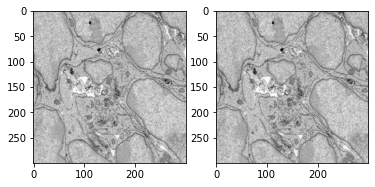

In [31]:
# Choose an image and it's filename from the dataset.
# Plot the tensor image as well as image given by the filename to see if they match.
num = 204
for images, labels in test_ds.take(1):
    print(images.shape, labels.shape)
    #plt.imshow(images[num].numpy()[:,:], cmap=plt.get_cmap("gray"))
    print(images[num].numpy().shape, labels[num].numpy().shape)
    print("Class label:", labels[num].numpy())
    print("Class name:", class_names[labels[num].numpy()])
    print("File name:", test_ds_filelist[num])

f = plt.figure()

f.add_subplot(1,2, 1)
test_img = cv2.imread(test_ds_filelist[num], 0)
plt.imshow(images[num].numpy()[:,:], cmap=plt.get_cmap("gray"))

f.add_subplot(1,2, 2)
plt.imshow(test_img, cmap=plt.get_cmap("gray"))

plt.show(block=True)


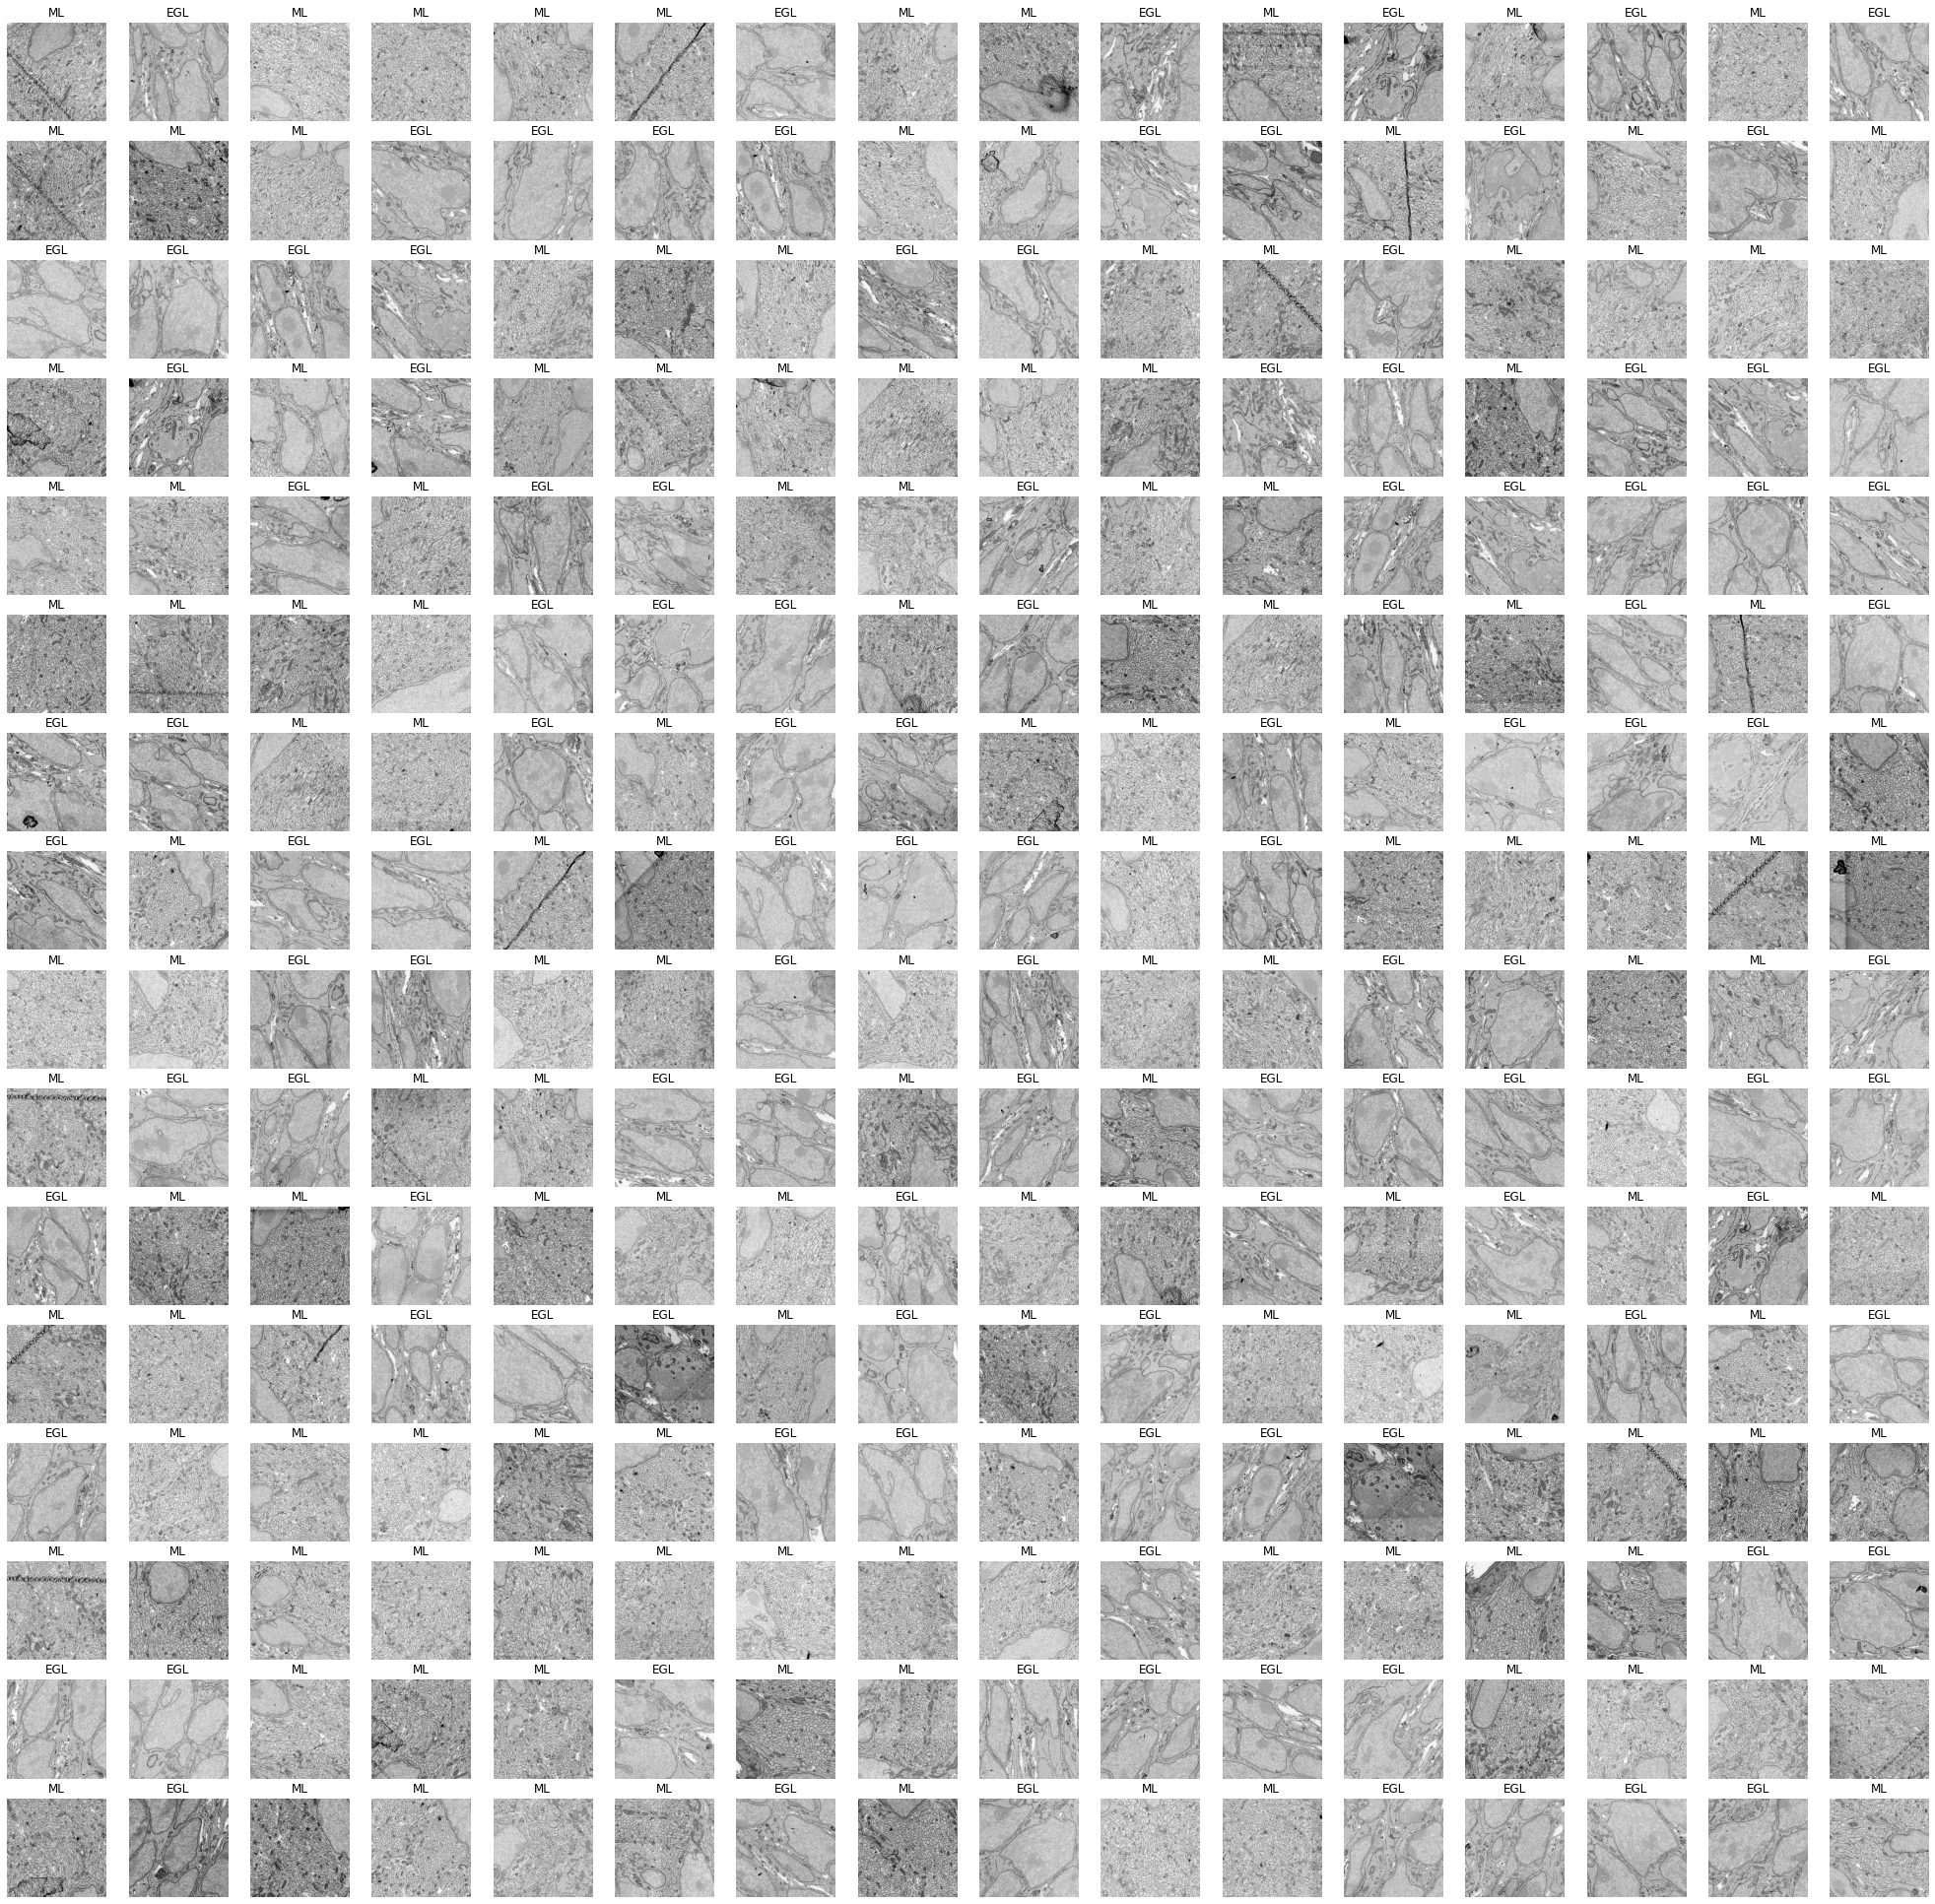

In [32]:
# Check if a batch of images from test dataset can be printed along with classnames and filenames
plt.figure(figsize=(35, 35))
cnt = 0
for images, labels in train_ds.take(1):
    #print(images.shape)
    for i in range(batch_size):
        ax = plt.subplot(int(np.sqrt(batch_size)), int(np.sqrt(batch_size)), i + 1)
        #ax = plt.subplot(16, 16, i + 1)
        #print(images[i].shape)
        plt.imshow(images[i].numpy(), cmap=plt.get_cmap("gray"))
        plt.title(class_names[labels[i]])
        #plt.title(class_names[labels[i]]+"\n"+test_ds_filelist[i+cnt*batch_size].split("/")[-1].replace(".png",""))
        plt.axis("off")
    cnt += 1

### Create Keras model

In [33]:
#Define model
model=tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer(input_shape=(img_height, img_width, 1)),
        ###keras.layers.Conv2D(32,(3,3), activation='relu', input_shape=input_shape),
        tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
        tf.keras.layers.MaxPool2D((2,2)),
        tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Conv2D(256,(3,3),activation='relu'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        #tf.keras.layers.Dense(1024, activation='relu'),
        #tf.keras.layers.BatchNormalization(),
        #tf.keras.layers.Dense(256, activation='relu'),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

#Compile the model
model.compile(
              optimizer=opt, 
              #optimizer='adam', 
              loss='binary_crossentropy',
              #loss='categorical_crossentropy',
              metrics=['acc']
              #metrics=['accuracy', 'f1score', 'precision', 'recall']
             )

#Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 256)       2

In [34]:
#Visualize model graphically
#tf.keras.utils.plot_model(model)

### Fit model to data

In [36]:
#Fitting the model
history = model.fit(train_ds,
                    #steps_per_epoch=100,#(image_count-val_size) // batch_size,
                    epochs=100,
                    #validation_steps=100,#val_size // batch_size,
                    validation_data=val_ds,
                    verbose=1
                   )

Epoch 1/100
6/6 [==============================] - 3s 445ms/step - loss: 0.1228 - acc: 0.9636 - val_loss: 0.5392 - val_acc: 0.6296
Epoch 2/100
6/6 [==============================] - 3s 453ms/step - loss: 0.0814 - acc: 0.9788 - val_loss: 0.5412 - val_acc: 0.5370
Epoch 3/100
6/6 [==============================] - 3s 440ms/step - loss: 0.0588 - acc: 0.9835 - val_loss: 0.4745 - val_acc: 0.8194
Epoch 4/100
6/6 [==============================] - 3s 442ms/step - loss: 0.0417 - acc: 0.9881 - val_loss: 0.4693 - val_acc: 0.7747
Epoch 5/100
6/6 [==============================] - 3s 447ms/step - loss: 0.0196 - acc: 0.9980 - val_loss: 0.4364 - val_acc: 0.9383
Epoch 6/100
6/6 [==============================] - 3s 443ms/step - loss: 0.0132 - acc: 0.9980 - val_loss: 0.4156 - val_acc: 0.9769
Epoch 7/100
6/6 [==============================] - 3s 438ms/step - loss: 0.0099 - acc: 0.9993 - val_loss: 0.4039 - val_acc: 0.9815
Epoch 8/100
6/6 [==============================] - 3s 441ms/step - loss: 0.0084 - a

Epoch 62/100
6/6 [==============================] - 3s 474ms/step - loss: 1.6645e-04 - acc: 1.0000 - val_loss: 0.0514 - val_acc: 0.9923
Epoch 63/100
6/6 [==============================] - 3s 441ms/step - loss: 2.5610e-04 - acc: 1.0000 - val_loss: 0.0499 - val_acc: 0.9923
Epoch 64/100
6/6 [==============================] - 3s 441ms/step - loss: 2.3580e-04 - acc: 1.0000 - val_loss: 0.0525 - val_acc: 0.9923
Epoch 65/100
6/6 [==============================] - 3s 440ms/step - loss: 1.6348e-04 - acc: 1.0000 - val_loss: 0.0461 - val_acc: 0.9938
Epoch 66/100
6/6 [==============================] - 3s 451ms/step - loss: 1.8619e-04 - acc: 1.0000 - val_loss: 0.0468 - val_acc: 0.9938
Epoch 67/100
6/6 [==============================] - 3s 442ms/step - loss: 2.0070e-04 - acc: 1.0000 - val_loss: 0.0479 - val_acc: 0.9923
Epoch 68/100
6/6 [==============================] - 3s 444ms/step - loss: 1.6180e-04 - acc: 1.0000 - val_loss: 0.0419 - val_acc: 0.9938
Epoch 69/100
6/6 [==============================

### Save model to file

In [ ]:
#model_filename = "models/model.10dec2020.data_mip3_aug.per_image_dataset"
#model_filename = "models/model4.data_mip3_aug.std_dataset"
#model.save(model_filename)

### Access model performance

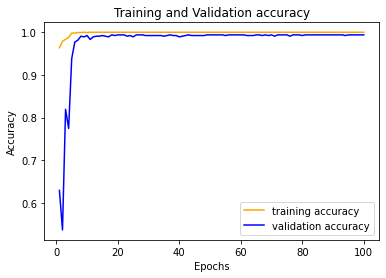

In [37]:
num_epochs = 100
acc_train = history.history['acc'][:num_epochs]
acc_val = history.history['val_acc'][:num_epochs]
epochs = range(1,num_epochs+1)
plt.plot(epochs,acc_train, 'orange', label='training accuracy')
plt.plot(epochs, acc_val, 'b', label= 'validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

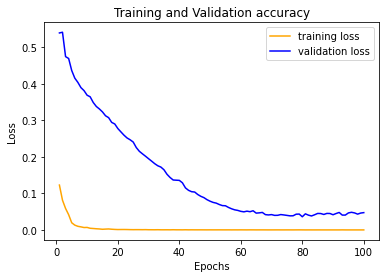

In [38]:
num_epochs = 100
loss_train = history.history['loss'][:num_epochs]
loss_val = history.history['val_loss'][:num_epochs]
epochs = range(1,num_epochs+1)
plt.plot(epochs,loss_train, 'orange', label='training loss')
plt.plot(epochs, loss_val, 'b', label= 'validation loss')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Generate classification report

In [39]:
def classification_report(true_labels, pred_labels):
    print("---Classification report---\n")
    confusion_matrix = metrics.confusion_matrix(true_labels, pred_labels)
    print("\t\t\tClassified as")
    print("\t\t"+"\t".join(class_names)+"\tsum")
    for i in range(0,len(class_names)):
        print(class_names[i]+"\t"+
              "\t\t".join([str(x) for x in confusion_matrix[i]])+
              "\t\t"+str(np.sum(confusion_matrix[i])))
    print("==========================================================\n")
    print("F1 scores:",metrics.f1_score(true_labels, pred_labels, average=None))
    print("==========================================================\n")
    print("metrics.classification_report:\n",metrics.classification_report(true_labels, pred_labels))

In [40]:
def get_true_pred_labels(model, dataset, num_batches):
    pred_1_to_10 = []
    pred_labels = []
    true_labels = []
    cnt = 0
    for images, labels in dataset.take(num_batches):
        #3print(images.shape, labels.shape)
        pred = model.predict(images)
        pred_temp = (pred*10).astype(int)
        #pred_temp = pred_temp.astype(int)
        #print(pred.shape, pred[:5].astype(int))
        #print(pred.shape)
        for i in range(0,pred.shape[0]):
            true_label = class_names[labels[i].numpy()]
            pred_label = class_names[int(pred[i][0]>0.5)]
            true_labels.append(true_label)
            pred_labels.append(pred_label)
            ##if true_label ==  'connection' and pred_label == 'no_connection':
                # ???Save image- Saving image is still under review
                #print(images[i].shape)
                #print(type(image), image.shape, image.min(), image.max())
                #img = Image.fromarray(np.array(255*image)).convert("L")#"RGB")#(images[i].numpy())#.astype('uint8'))
                #img.save("data_mip3/test_connection_as_noconnection/image_"+str(cnt)+".png")
                ##image = images[i].numpy()
                ##image = np.squeeze(image)
                ##image = images[5].astype('uint8')
                ##Image.fromarray(images[6].astype('uint8')).save("image_6.png")

            pred_1_to_10.append(pred_temp[i])
            cnt += 1
    pred_1_to_10 = np.array(pred_1_to_10)
    plt.hist(pred_1_to_10, bins=10) # This is to see histogram of predictions
    true_labels = np.array(true_labels)
    pred_labels = np.array(pred_labels)
    print(true_labels.shape, pred_labels.shape)
    print("Unique counts in true_labels:", np.unique(true_labels, return_counts=True))
    print("Unique counts in pred_labels:", np.unique(pred_labels, return_counts=True))
    print()
    return(true_labels, pred_labels)

(540,) (540,)
Unique counts in true_labels: (array(['EGL', 'ML'], dtype='<U3'), array([270, 270]))
Unique counts in pred_labels: (array(['EGL', 'ML'], dtype='<U3'), array([288, 252]))

---Classification report---

			Classified as
		EGL	ML	sum
EGL	270		0		270
ML	18		252		270

F1 scores: [0.96774194 0.96551724]

metrics.classification_report:
               precision    recall  f1-score   support

         EGL       0.94      1.00      0.97       270
          ML       1.00      0.93      0.97       270

    accuracy                           0.97       540
   macro avg       0.97      0.97      0.97       540
weighted avg       0.97      0.97      0.97       540



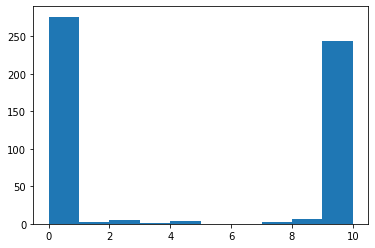

In [41]:
# Classification report for test dataset
true_labels, pred_labels = get_true_pred_labels(model, test_ds, 200)
classification_report(true_labels, pred_labels)

(1512,) (1512,)
Unique counts in true_labels: (array(['EGL', 'ML'], dtype='<U3'), array([749, 763]))
Unique counts in pred_labels: (array(['EGL', 'ML'], dtype='<U3'), array([749, 763]))

---Classification report---

			Classified as
		EGL	ML	sum
EGL	749		0		749
ML	0		763		763

F1 scores: [1. 1.]

metrics.classification_report:
               precision    recall  f1-score   support

         EGL       1.00      1.00      1.00       749
          ML       1.00      1.00      1.00       763

    accuracy                           1.00      1512
   macro avg       1.00      1.00      1.00      1512
weighted avg       1.00      1.00      1.00      1512



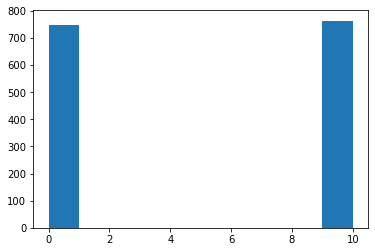

In [42]:
# Classification report for training dataset
true_labels, pred_labels = get_true_pred_labels(model, train_ds, 100)
classification_report(true_labels, pred_labels)

In [ ]:
# Classification report for validation dataset
true_labels, pred_labels = get_true_pred_labels(model, val_ds, 100)
classification_report(true_labels, pred_labels)